# Accident-Eye: YOLO-XGBoost

##Imports

In [ ]:
import torch
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import os
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import csv
import h5py
import numpy as np
from pathlib import Path
from sklearn.decomposition import PCA

### YOLO features extraction

In [ ]:
# Define hook function
def hook_fn(module, input, output):
    intermediate_features.append(output)

# Define feature extraction function
def extract_features(model, img, layer_index=20):
    global intermediate_features
    intermediate_features = []
    hook = model.model.model[layer_index].register_forward_hook(hook_fn)
    with torch.no_grad():
        model(img)
    hook.remove()
    return intermediate_features[0]  # Access the first element of the list

# Preprocess image function
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.Grayscale(num_output_channels=3),  # Convert to RGB
        transforms.ToTensor(),
        transforms.Normalize(mean=0., std=1.)  # Normalize if needed
    ])
    img = Image.open(img_path)
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension
    return img


In [ ]:
# Load YOLOv8 model
model = YOLO("best.pt")

print(model.model)

ClassificationModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
  

# Save the features as .h5

### Save the train features as .h5

In [ ]:

# Define dataset directory
train_dir = Path("Dataset/train")  # Update with your dataset path
output_hdf5_path = "features_train.h5"

# Create HDF5 file to store features
with h5py.File(output_hdf5_path, "w") as hdf5_file:
    # Prepare datasets for features and labels
    feature_dataset = hdf5_file.create_dataset("features", (0, 76800), maxshape=(None, 76800), dtype='float32')
    label_dataset = hdf5_file.create_dataset("labels", (0,), maxshape=(None,), dtype=h5py.string_dtype(encoding='utf-8'))

    # Iterate through each class folder and extract features for images
    for class_folder in train_dir.iterdir():
        if class_folder.is_dir():  # Check if it's a folder
            class_name = class_folder.name
            for img_file in class_folder.iterdir():
                if img_file.suffix.lower() in [".jpg", ".png", ".jpeg"]:  # Check for image files
                    print(f"Processing: {img_file}")

                    # Preprocess and extract features
                    img = preprocess_image(img_file)
                    features = extract_features(model, img, layer_index=8)
                    features_flat = features.cpu().numpy().flatten()  # Flatten the features to 1D

                    # Append features and class labels to Arrays
                    feature_dataset.resize((feature_dataset.shape[0] + 1, 76800))
                    feature_dataset[-1:] = features_flat
                    label_dataset.resize((label_dataset.shape[0] + 1,))
                    label_dataset[-1:] = [class_name]

print(f"Feature extraction completed and saved to '{output_hdf5_path}'.")




Processing: C:\Users\Admin\Desktop\YOLO+XGB\dataset123n_train_test\train\1\1000_jpg.rf.5d7291be0ad6f57604b83a3abc08221d.jpg

0: 320x320 1 1.00, 3 0.00, 2 0.00, NonAccident 0.00, 44.1ms
Speed: 0.0ms preprocess, 44.1ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 320)
Processing: C:\Users\Admin\Desktop\YOLO+XGB\dataset123n_train_test\train\1\1000_jpg.rf.7b9890554fdc19252532c7156caab30f.jpg

0: 320x320 1 1.00, 3 0.00, 2 0.00, NonAccident 0.00, 34.9ms
Speed: 0.8ms preprocess, 34.9ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 320)
Processing: C:\Users\Admin\Desktop\YOLO+XGB\dataset123n_train_test\train\1\1000_jpg.rf.8cdc0c89b498a2b2077f3c0ac733cb43.jpg

0: 320x320 1 1.00, 3 0.00, 2 0.00, NonAccident 0.00, 46.7ms
Speed: 0.0ms preprocess, 46.7ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 320)
Processing: C:\Users\Admin\Desktop\YOLO+XGB\dataset123n_train_test\train\1\1000_jpg.rf.acd1d5e1529b97731e0c9e9844622981.jpg

0: 320x320 1 1.00, 3 0.00, 2 

### Save the test features as .h5

In [ ]:
# Define dataset directory
train_dir = Path("Dataset/test")  # Update with your dataset path
output_hdf5_path = "features_test.h5"

# Create HDF5 file to store features
with h5py.File(output_hdf5_path, "w") as hdf5_file:
    # Prepare datasets for features and labels
    feature_dataset = hdf5_file.create_dataset("features", (0, 76800), maxshape=(None, 76800), dtype='float32')
    label_dataset = hdf5_file.create_dataset("labels", (0,), maxshape=(None,), dtype=h5py.string_dtype(encoding='utf-8'))

    # Iterate through each class folder and extract features for images
    for class_folder in train_dir.iterdir():
        if class_folder.is_dir():  # Check if it's a folder
            class_name = class_folder.name
            for img_file in class_folder.iterdir():
                if img_file.suffix.lower() in [".jpg", ".png", ".jpeg"]:  # Check for image files
                    print(f"Processing: {img_file}")

                    # Preprocess and extract features
                    img = preprocess_image(img_file)
                    features = extract_features(model, img, layer_index=8)
                    features_flat = features.cpu().numpy().flatten()  # Flatten the features to 1D

                    # Append features and class labels to Arrays
                    feature_dataset.resize((feature_dataset.shape[0] + 1, 76800))
                    feature_dataset[-1:] = features_flat
                    label_dataset.resize((label_dataset.shape[0] + 1,))
                    label_dataset[-1:] = [class_name]

print(f"Feature extraction completed and saved to '{output_hdf5_path}'.")

Processing: C:\Users\Admin\Desktop\YOLO+XGB\dataset123n_train_test\test\1\1001_jpg.rf.82dac69f111098ca99590870f1818abd.jpg

0: 320x320 1 1.00, 2 0.00, 3 0.00, NonAccident 0.00, 11.6ms
Speed: 0.0ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 320)
Processing: C:\Users\Admin\Desktop\YOLO+XGB\dataset123n_train_test\test\1\1002_jpg.rf.8ab9dce9e575d9420cea1b5d5a2a0051.jpg

0: 320x320 1 1.00, NonAccident 0.00, 2 0.00, 3 0.00, 4.3ms
Speed: 0.0ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 320)
Processing: C:\Users\Admin\Desktop\YOLO+XGB\dataset123n_train_test\test\1\1002_jpg.rf.db7671e8aeb8a798a1108fbf90f19640.jpg

0: 320x320 1 1.00, 3 0.00, 2 0.00, NonAccident 0.00, 3.1ms
Speed: 1.0ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 320, 320)
Processing: C:\Users\Admin\Desktop\YOLO+XGB\dataset123n_train_test\test\1\1003_jpg.rf.bdaa925f65d13db6d5e7c98c77411912.jpg

0: 320x320 1 1.00, 2 0.00, 3 0.00, No

# PCA

- Load features from HDF5 file

In [ ]:
import numpy as np
import h5py
output_hdf5_path = "features_train.h5"
with h5py.File(output_hdf5_path, "r") as hdf5_file:
    features = np.array(hdf5_file["features"])
    print("Features shape:", features.shape)

    labels = np.array(hdf5_file["labels"])
    print("Labels shape:", labels.shape)

    # Print the first instance of features and labels
    print("First instance in features:", features[0])
    print("First instance in labels:", labels[0])

Features shape: (13501, 76800)
Labels shape: (13501,)
First instance in features: [  -0.010433   -0.042598    -0.27013 ...    -0.14043    -0.14972    -0.25696]
First instance in labels: b'1'


- Scaler and PCA fit on train data

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import h5py

In [ ]:
output_hdf5_path = "features_train.h5"

# Load data from the HDF5 file
with h5py.File(output_hdf5_path, "r") as hdf5_file:
    features = np.array(hdf5_file["features"])  # Load features

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Fit PCA on scaled data
pca = PCA()
pca.fit(scaled_data)

PCA()

- Get best Number of components for PCA

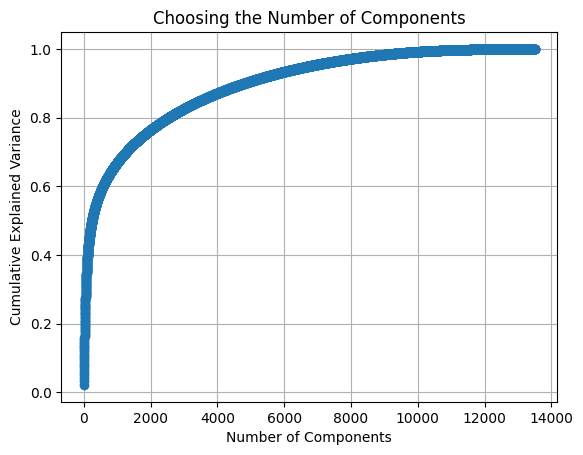

Number of components to retain 95% variance: 6749


In [ ]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative variance
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Choosing the Number of Components')
plt.grid()
plt.show()

# Choose components that explain 95% variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

- Transform features using PCA on train data

In [ ]:
# Apply PCA to reduce dimensions
pca = PCA(n_components=6749)  # Reduce to 100 components
reduced_features = pca.fit_transform(features)

# Save reduced features
np.save("reduced_features.npy", reduced_features)
np.save("labels.npy", labels)

print("PCA completed and reduced features saved to 'reduced_features.npy'.")

PCA completed and reduced features saved to 'reduced_features.npy'.


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\numpy\lib\format.py:383: UserWarning: metadata on a dtype is not saved to an npy/npz. Use another format (such as pickle) to store it.
  d['descr'] = dtype_to_descr(array.dtype)


- Save PCA model to reuse for test set

In [ ]:
import joblib  # To save and load PCA model

# Save PCA model to reuse for test and validation sets
joblib.dump(pca, "pca_model.pkl")

['pca_model.pkl']

- Transform features using PCA on test data

In [ ]:
import joblib
output_hdf5_path = "features_test.h5"

# Load features and labels for PCA
with h5py.File(output_hdf5_path, "r") as hdf5_file:
    features_test = np.array(hdf5_file["features"])
    print(features.shape)
    labels_test = np.array(hdf5_file["labels"])
    print(labels_test.shape)


pca_load = joblib.load("pca_model.pkl")

# Apply PCA transformation to test and validation sets
reduced_test_features = pca_load.transform(features_test)
np.save("reduced_test_features.npy", reduced_test_features)
np.save("labels_test.npy", labels_test)

(13501, 76800)
(3377,)


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\numpy\lib\format.py:383: UserWarning: metadata on a dtype is not saved to an npy/npz. Use another format (such as pickle) to store it.
  d['descr'] = dtype_to_descr(array.dtype)


### Imports

In [ ]:
import optuna
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Load Data

In [ ]:
# Load train data from .npy files
train_features = np.load('reduced_features.npy')
train_labels = np.load('labels.npy', allow_pickle=True)
unique_labels = np.unique(train_labels)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
numeric_labels_train = np.array([label_mapping[label] for label in train_labels])

# Load test data from .npy files
test_features = np.load('reduced_test_features.npy')
test_labels = np.load('labels_test.npy', allow_pickle=True)
unique_labels = np.unique(test_labels)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
numeric_labels_test = np.array([label_mapping[label] for label in test_labels])

# Prepare DMatrix for XGBoost
dtrain = xgb.DMatrix(train_features, label=numeric_labels_train)
dtest = xgb.DMatrix(test_features, label=numeric_labels_test)

# Watchlist to evaluate model on training and validation datasets
watchlist=[(dtrain, 'train'), (dtest, 'eval')]

# Baysaian optimizer

In [ ]:
# Objective function for Optunaz
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'objective': 'multi:softmax', # For multi-class classification
        'num_class': len(np.unique(numeric_labels_train)),  # Set the number of classes
        'eval_metric': 'mlogloss', # Multi-class log-loss
        'eta': trial.suggest_float('eta', 0.01, 0.3, step=0.01),# Updated learning rate
        'max_depth': trial.suggest_int('max_depth', 3, 10),# Updated max depth of trees
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1), # Updated subsample ratio
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1), # Updated column sample ratio by tree
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),  # L2 regularization
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True)    # L1 regularization
    }

    # Define the number of boosting rounds to try
    num_boost_round = trial.suggest_int('num_boost_round', 50, 500, step=50)

    # Train the model
    evals_result = {}
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=False
    )

    # Validate on validation set
    val_predictions = bst.predict(dtest)
    val_accuracy = accuracy_score(numeric_labels_test, val_predictions)

    # Objective is to maximize validation accuracy
    return val_accuracy

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Run for 50 trials

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-01-27 17:22:22,431] A new study created in memory with name: no-name-a6485f13-095b-480f-a576-6ec75ba9e0e4
[I 2025-01-27 17:33:50,712] Trial 0 finished with value: 0.9384068700029612 and parameters: {'eta': 0.13, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.7, 'lambda': 1.0206240102560469, 'alpha': 0.03700771451319871, 'num_boost_round': 400}. Best is trial 0 with value: 0.9384068700029612.
[I 2025-01-27 17:50:37,655] Trial 1 finished with value: 0.9381107491856677 and parameters: {'eta': 0.09999999999999999, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 1.0, 'lambda': 0.04113540827866686, 'alpha': 0.20901216292471356, 'num_boost_round': 150}. Best is trial 0 with value: 0.9384068700029612.
[I 2025-01-27 17:57:20,624] Trial 2 finished with value: 0.939591353272135 and parameters: {'eta': 0.23, 'max_depth': 6, 'subsample': 1.0, 'colsample_bytree': 0.5, 'lambda': 3.4971545742038854, 'alpha': 0.022226719192721442, 'num_boost_round': 400}. Best is trial 2 with va

Best Hyperparameters: {'eta': 0.14, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'lambda': 0.3387369057393214, 'alpha': 2.5620177743702985, 'num_boost_round': 450}


# XGBoost

- Train Xgboost on best Hyperparameters

In [ ]:
# Best  Hyperparameters form Baysaian optimizer
params = {
    'objective': 'multi:softprob',  # For multi-class classification with probabilities
    'num_class': len(np.unique(numeric_labels_train)),  # Set Number of classes
    'eval_metric': 'mlogloss',    # Multi-class log-loss
    'eta': 0.14, # Updated learning rate
    'max_depth': 3, # Updated max depth of trees
    'subsample': 0.5, # Updated subsample ratio
    'colsample_bytree': 0.7, # Updated column sample ratio by tree
    'lambda': 0.3387369057393214,# Updated L2 regularization
    'alpha': 2.5620177743702985, # Updated L1 regularization
}

# Custom evaluation function to calculate accuracy
def accuracy_eval(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.argmax(preds, axis=1)  # Get the predicted class
    acc = accuracy_score(labels, preds)
    return 'accuracy', acc

# Train the model
evals_result = {}
num_boost_round = 450
bst = xgb.train(params, dtrain, num_boost_round, watchlist,
                 evals_result=evals_result,
                feval=accuracy_eval, maximize=True)

# Evaluate on test data
test_predictions = np.argmax(bst.predict(dtest), axis=1)  # Get class predictions
accuracy = accuracy_score(numeric_labels_test, test_predictions)
conf_matrix = confusion_matrix(numeric_labels_test, test_predictions)
class_report = classification_report(numeric_labels_test, test_predictions)



C:\Users\dokhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
C:\Users\dokhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-mlogloss:1.26719	train-accuracy:0.76431	eval-mlogloss:1.27216	eval-accuracy:0.74267
[1]	train-mlogloss:1.18004	train-accuracy:0.79942	eval-mlogloss:1.18959	eval-accuracy:0.77672
[2]	train-mlogloss:1.09939	train-accuracy:0.82586	eval-mlogloss:1.11366	eval-accuracy:0.80190
[3]	train-mlogloss:1.02988	train-accuracy:0.82957	eval-mlogloss:1.04713	eval-accuracy:0.80545
[4]	train-mlogloss:0.96920	train-accuracy:0.84335	eval-mlogloss:0.98969	eval-accuracy:0.81907
[5]	train-mlogloss:0.91346	train-accuracy:0.84979	eval-mlogloss:0.93656	eval-accuracy:0.82262
[6]	train-mlogloss:0.86686	train-accuracy:0.86327	eval-mlogloss:0.89098	eval-accuracy:0.83328
[7]	train-mlogloss:0.82000	train-accuracy:0.86468	eval-mlogloss:0.84546	eval-accuracy:0.83891
[8]	train-mlogloss:0.78312	train-accuracy:0.86971	eval-mlogloss:0.81015	eval-accuracy:0.84661
[9]	train-mlogloss:0.74315	train-accuracy:0.87534	eval-mlogloss:0.77119	eval-accuracy:0.85016
[10]	train-mlogloss:0.70818	train-accuracy:0.87882	eval-mlog

- Final results on training and testing

In [ ]:
# Convert probabilities to class labels
train_predictions = np.argmax(bst.predict(dtrain), axis=1)

train_accuracy = accuracy_score(numeric_labels_train, train_predictions)
# Print training , Test accuracy and loss
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {accuracy}")
print()
print(f"Final Training Loss: {evals_result['train']['mlogloss'][-1]}")
print(f"Final Test Loss: {evals_result['eval']['mlogloss'][-1]}")

# Classification report for training set
print("Training Set Classification Report:")
print(classification_report(numeric_labels_train, train_predictions))
print()
# Classification report for Test set
print(" Test Set Classification Report:")
print(class_report)

# Print Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

Training Accuracy: 0.999925931412488
Test Accuracy: 0.9458098904352976

Final Training Loss: 0.02152945658706576
Final Test Loss: 0.16186270626055044
Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3477
           1       1.00      1.00      1.00      3460
           2       1.00      1.00      1.00      3252
           3       1.00      1.00      1.00      3312

    accuracy                           1.00     13501
   macro avg       1.00      1.00      1.00     13501
weighted avg       1.00      1.00      1.00     13501


 Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       870
           1       0.94      0.93      0.93       866
           2       0.93      0.93      0.93       813
           3       0.94      0.97      0.96       828

    accuracy                           0.95      3377
   macro avg       

- Visualizing Loss , Accuracy and confusion on Training and Test Data

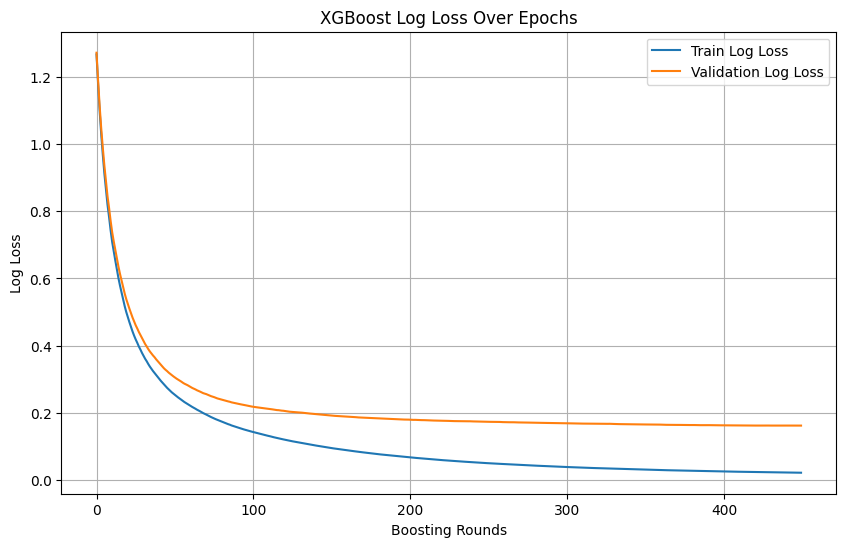

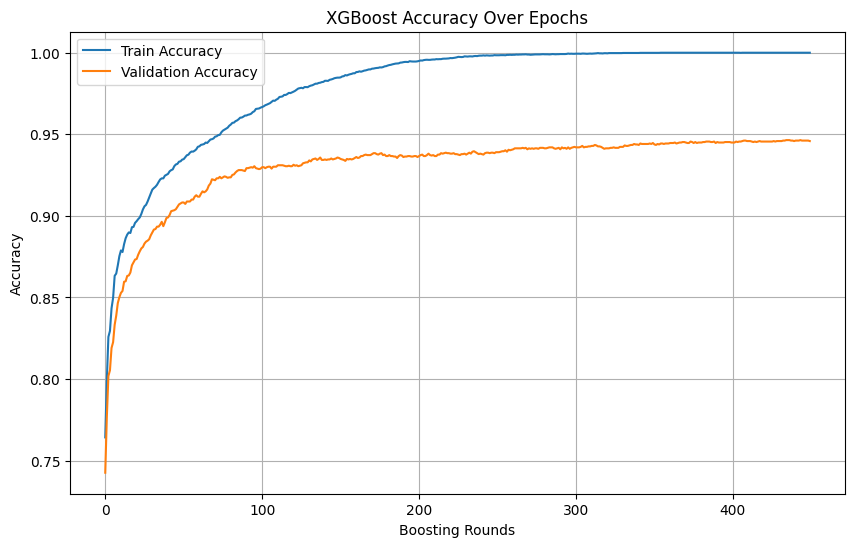

<Figure size 800x600 with 0 Axes>

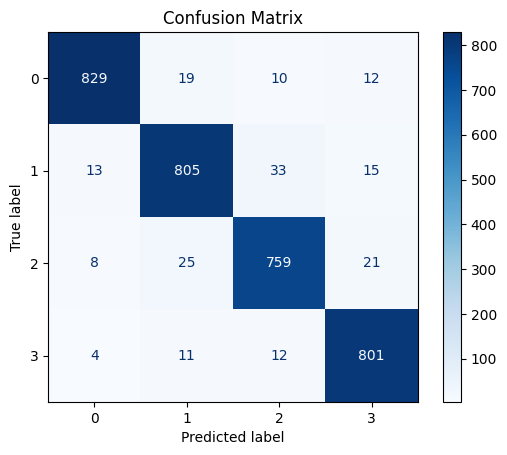

In [ ]:
# Plot training and validation log-loss
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['train']['mlogloss'], label='Train Log Loss')
plt.plot(x_axis, evals_result['eval']['mlogloss'], label='Validation Log Loss')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
train_accuracy = evals_result['train']['accuracy']
val_accuracy = evals_result['eval']['accuracy']

plt.figure(figsize=(10, 6))
plt.plot(x_axis, train_accuracy, label='Train Accuracy')
plt.plot(x_axis, val_accuracy, label='Validation Accuracy')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(numeric_labels_test))
cmd.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model if needed
bst.save_model('xgboost_model.json')